In [8]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data

In [9]:


class GaussianMixtureModel:
    
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [10]:
np.random.seed(42)
gmm = GaussianMixtureModel(k=3, max_iter=10)
gmm.fit(X)

In [12]:
permutation = np.array([
    mode(iris.target[gmm.predict(X) == i]).mode.item() 
    for i in range(gmm.k)])
permuted_prediction = permutation[gmm.predict(X)]
print(np.mean(iris.target == permuted_prediction))
confusion_matrix(iris.target, permuted_prediction)


0.96


array([[50,  0,  0],
       [ 0, 44,  6],
       [ 0,  0, 50]])

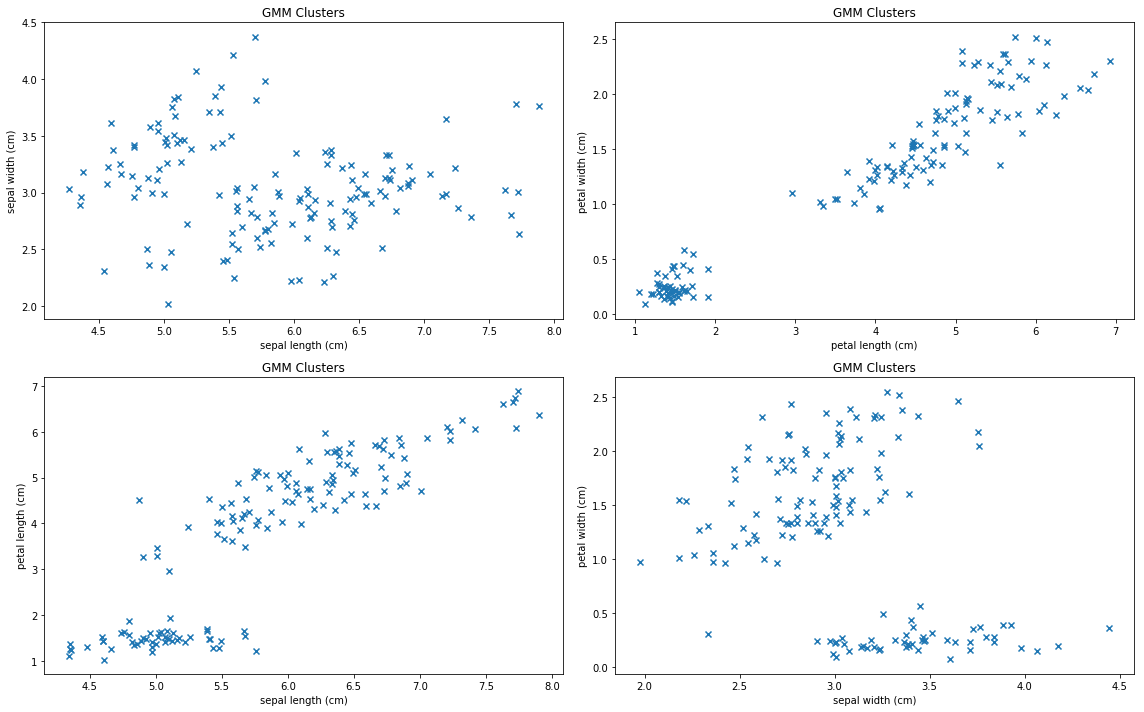

In [13]:
def jitter(x):
    return x + np.random.uniform(low=-0.05, high=0.05, size=x.shape)

def plot_axis_pairs(X, axis_pairs, clusters, classes):
    n_rows = len(axis_pairs) // 2
    n_cols = 2
    plt.figure(figsize=(16, 10))
    for index, (x_axis, y_axis) in enumerate(axis_pairs):
        plt.subplot(n_rows, n_cols, index+1)
        plt.title('GMM Clusters')
        plt.xlabel(iris.feature_names[x_axis])
        plt.ylabel(iris.feature_names[y_axis])
        plt.scatter(
            jitter(X[:, x_axis]), 
            jitter(X[:, y_axis]), 
            #c=clusters, 
            cmap=plt.cm.get_cmap('brg'),
            marker='x')
    plt.tight_layout()
    
plot_axis_pairs(
    X=X,
    axis_pairs=[ 
        (0,1), (2,3), 
        (0,2), (1,3) ],
    clusters=permuted_prediction,
    classes=iris.target)